In [28]:
"""
Customer Churn Prediction Analysis using Machine Learning Algorithms
===================================================================
This script performs comprehensive customer churn prediction analysis using multiple ML algorithms
with statistical validation and SHAP explainability for journal publication.

Authors: [Your Name]
Date: June 2024
Journal: [Target Journal Name]
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, precision_recall_curve, auc)
from scipy.stats import wilcoxon, friedmanchisquare
import joblib

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create output directory
OUTPUT_DIR = "rill_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/data", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

print("="*80)
print("CUSTOMER CHURN PREDICTION ANALYSIS")
print("="*80)
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {OUTPUT_DIR}")

# === STEP 1: DATA LOADING AND EXPLORATION ===
print("\n" + "="*50)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*50)

try:
    df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
    print(f"✓ Dataset loaded successfully")
    print(f"Dataset shape: {df.shape}")

    # Basic dataset information
    print(f"\nDataset Info:")
    print(f"- Total samples: {len(df)}")
    print(f"- Total features: {len(df.columns)}")
    print(f"- Missing values: {df.isnull().sum().sum()}")

except FileNotFoundError:
    print("❌ Dataset file not found. Please check the file path.")
    exit()


CUSTOMER CHURN PREDICTION ANALYSIS
Analysis started at: 2025-06-16 22:30:50
Output directory: rill_final

STEP 1: DATA LOADING AND EXPLORATION
✓ Dataset loaded successfully
Dataset shape: (7043, 21)

Dataset Info:
- Total samples: 7043
- Total features: 21
- Missing values: 0



STEP 2: DATA PREPROCESSING
✓ Column names normalized
Processing TotalCharges column...
Missing values in TotalCharges: 11
✓ Removed 11 rows with missing values
Final dataset shape: (7032, 21)
✓ Customer ID column removed

Target Variable Distribution:
- No: 5163 (73.42%)
- Yes: 1869 (26.58%)


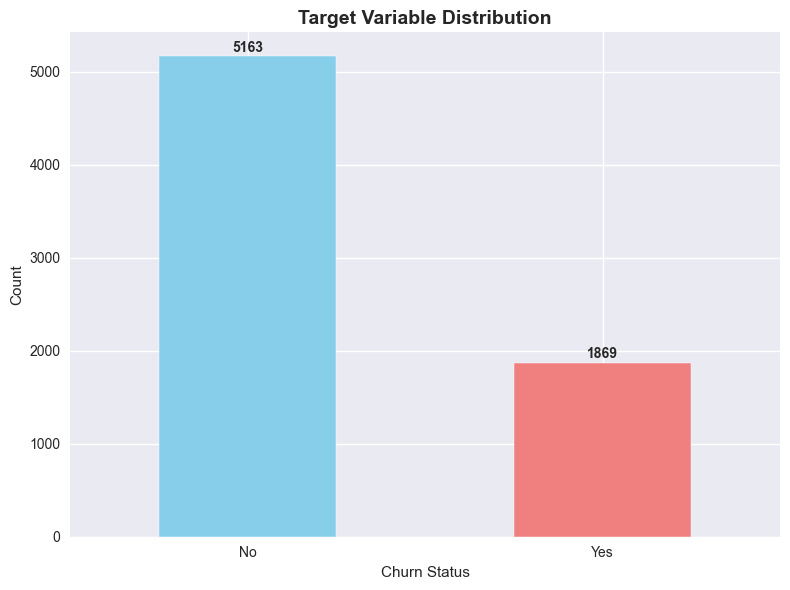

In [29]:

# === STEP 2: DATA PREPROCESSING ===
print("\n" + "="*50)
print("STEP 2: DATA PREPROCESSING")
print("="*50)

# Normalize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")
print("✓ Column names normalized")

# Handle TotalCharges conversion
print("Processing TotalCharges column...")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
missing_before = df['TotalCharges'].isnull().sum()
print(f"Missing values in TotalCharges: {missing_before}")

# Remove rows with missing values
df.dropna(inplace=True)
print(f"✓ Removed {missing_before} rows with missing values")
print(f"Final dataset shape: {df.shape}")

# Remove customer ID
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)
    print("✓ Customer ID column removed")

# Analyze target variable distribution
target_dist = df['Churn'].value_counts()
print(f"\nTarget Variable Distribution:")
for label, count in target_dist.items():
    percentage = (count / len(df)) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

# Create class distribution plot
plt.figure(figsize=(8, 6))
target_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_dist.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()



STEP 3: FEATURE ENGINEERING
Categorical features to encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
✓ One-hot encoding completed
Features after encoding: 30
Final feature matrix shape: (7032, 30)
Target variable shape: (7032,)


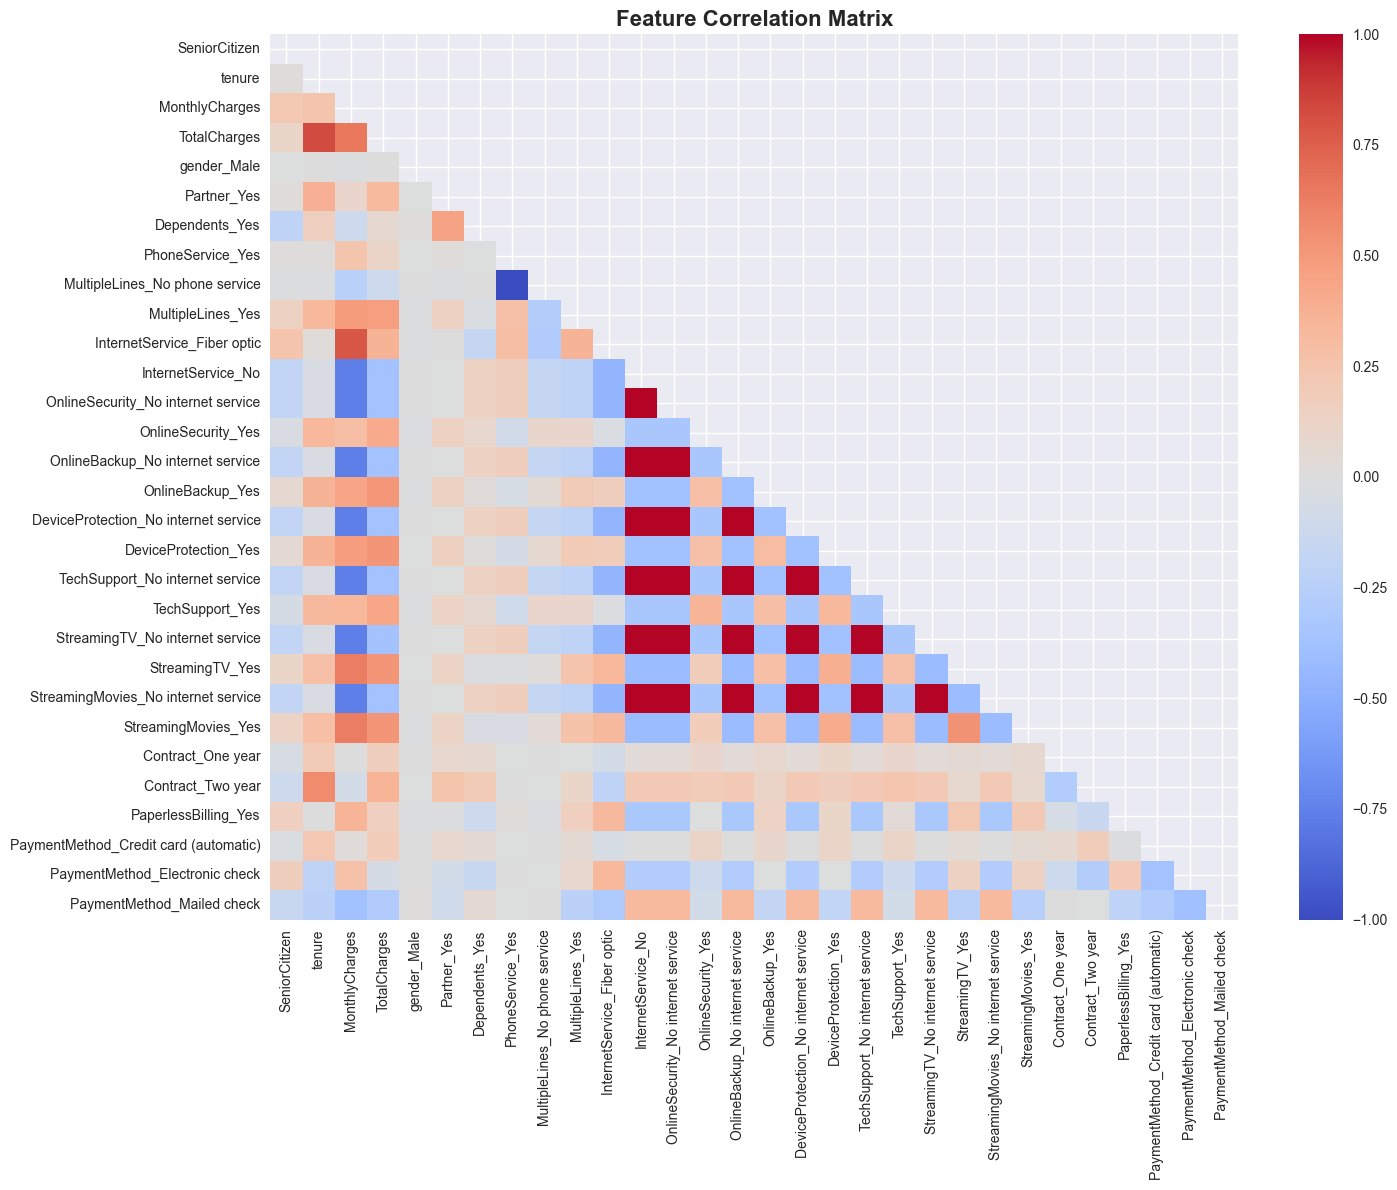

In [30]:

# === STEP 3: FEATURE ENGINEERING ===
print("\n" + "="*50)
print("STEP 3: FEATURE ENGINEERING")
print("="*50)

# One-hot encoding for categorical variables
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')

print(f"Categorical features to encode: {categorical_features}")
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
print(f"✓ One-hot encoding completed")
print(f"Features after encoding: {df_encoded.shape[1] - 1}")

# Prepare features and target
X = df_encoded.drop("Churn", axis=1)
y = (df_encoded["Churn"] == "Yes").astype(int)  # Convert to binary

print(f"Final feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Feature correlation analysis
plt.figure(figsize=(15, 12))
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [31]:

# === STEP 4: DATA SCALING AND SPLITTING ===
print("\n" + "="*50)
print("STEP 4: DATA SCALING AND SPLITTING")
print("="*50)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Feature scaling completed")

# Save scaler
joblib.dump(scaler, f"{OUTPUT_DIR}/models/scaler.pkl")
print("✓ Scaler saved")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")



STEP 4: DATA SCALING AND SPLITTING
✓ Feature scaling completed
✓ Scaler saved
Training set shape: (5625, 30)
Testing set shape: (1407, 30)
Training set class distribution: [4130 1495]
Testing set class distribution: [1033  374]


In [32]:

# === STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING ===
print("\n" + "="*50)
print("STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING")
print("="*50)

# Define models with hyperparameter grids for tuning
models_config = {
    "GBM": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3, 5]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    },
    "SVC": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    "NeuralNet": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "params": {
            'hidden_layer_sizes': [(100,), (100, 50)],
            'alpha': [0.001, 0.01]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.5, 1.0, 1.5]
        }
    }
}

# Perform hyperparameter tuning (simplified for demonstration)
print("Performing hyperparameter tuning...")
tuned_models = {}
for name, config in models_config.items():
    print(f"Tuning {name}...")
    # Use a subset of parameters for faster execution
    simple_params = {k: v[:2] if len(v) > 2 else v for k, v in config["params"].items()}

    grid_search = GridSearchCV(
        config["model"],
        simple_params,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    tuned_models[name] = grid_search.best_estimator_
    print(f"✓ {name} best score: {grid_search.best_score_:.4f}")



STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING
Performing hyperparameter tuning...
Tuning GBM...
✓ GBM best score: 0.8471
Tuning XGBoost...
✓ XGBoost best score: 0.8490
Tuning RandomForest...
✓ RandomForest best score: 0.8432
Tuning LogisticRegression...
✓ LogisticRegression best score: 0.8468
Tuning SVC...
✓ SVC best score: 0.8369
Tuning NeuralNet...
✓ NeuralNet best score: 0.7901
Tuning AdaBoost...
✓ AdaBoost best score: 0.8437



STEP 6: CROSS-VALIDATION EVALUATION
Performing 10-fold cross-validation...
--------------------------------------------------------------------------------
Model           ROC-AUC      Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------------------------------------
GBM             0.8477±0.006 0.8035±0.011 0.6739±0.032 0.5072±0.030 0.5782±0.025
XGBoost         0.8476±0.006 0.8018±0.009 0.6614±0.027 0.5233±0.018 0.5839±0.016
RandomForest    0.8427±0.006 0.8018±0.011 0.6661±0.031 0.5115±0.026 0.5782±0.024
LogisticRegression 0.8450±0.004 0.8033±0.009 0.6555±0.021 0.5484±0.021 0.5971±0.019
SVC             0.8339±0.004 0.7988±0.012 0.6471±0.029 0.5356±0.024 0.5859±0.023
NeuralNet       0.7939±0.016 0.7676±0.016 0.5747±0.039 0.5062±0.042 0.5362±0.025
AdaBoost        0.8484±0.005 0.8042±0.010 0.6742±0.028 0.5109±0.026 0.5809±0.022


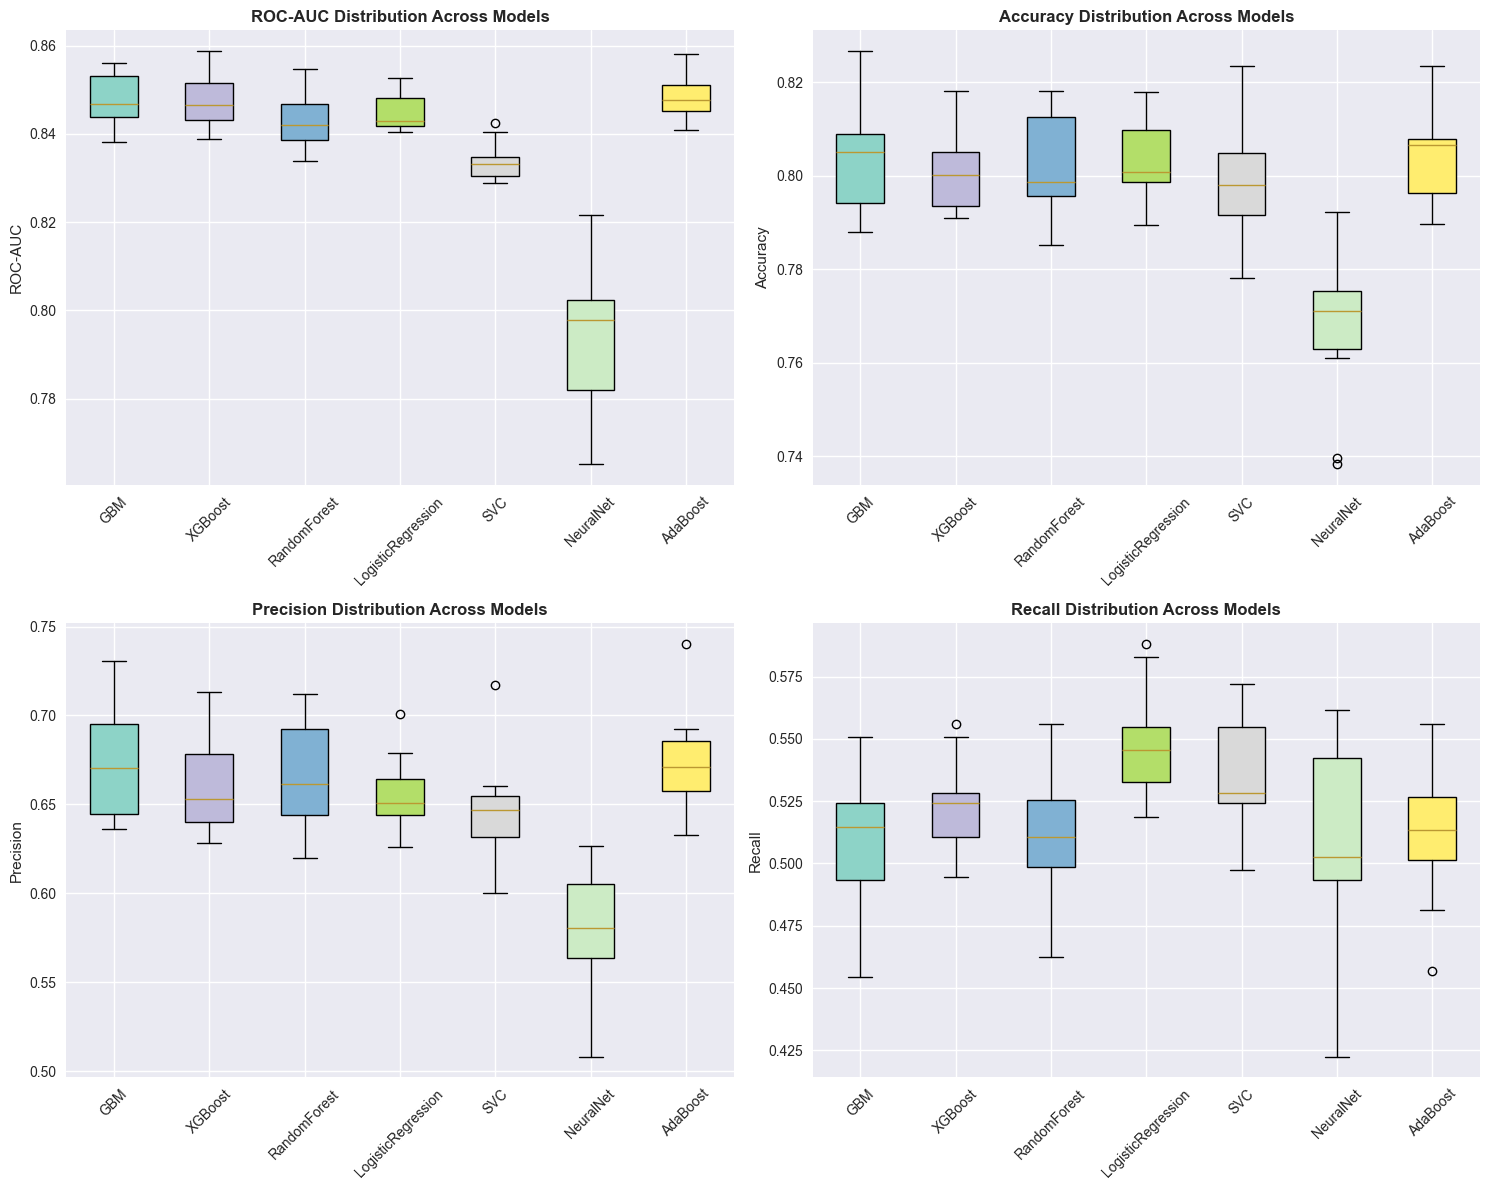

In [33]:

# === STEP 6: CROSS-VALIDATION EVALUATION ===
print("\n" + "="*50)
print("STEP 6: CROSS-VALIDATION EVALUATION")
print("="*50)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = {}
metrics_results = {}

print("Performing 10-fold cross-validation...")
print("-" * 80)
print(f"{'Model':<15} {'ROC-AUC':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 80)

for name, model in tuned_models.items():
    # ROC-AUC scores
    roc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
    acc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    prec_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='precision')
    rec_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='recall')
    f1_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1')

    cv_results[name] = roc_scores
    metrics_results[name] = {
        'roc_auc': roc_scores,
        'accuracy': acc_scores,
        'precision': prec_scores,
        'recall': rec_scores,
        'f1': f1_scores
    }

    print(f"{name:<15} {roc_scores.mean():.4f}±{roc_scores.std():.3f} "
          f"{acc_scores.mean():.4f}±{acc_scores.std():.3f} "
          f"{prec_scores.mean():.4f}±{prec_scores.std():.3f} "
          f"{rec_scores.mean():.4f}±{rec_scores.std():.3f} "
          f"{f1_scores.mean():.4f}±{f1_scores.std():.3f}")

# Create performance comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['roc_auc', 'accuracy', 'precision', 'recall']
titles = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx//2, idx%2]
    data = [metrics_results[model][metric] for model in tuned_models.keys()]
    labels = list(tuned_models.keys())

    bp = ax.boxplot(data, labels=labels, patch_artist=True)
    ax.set_title(f'{title} Distribution Across Models', fontweight='bold')
    ax.set_ylabel(title)
    ax.tick_params(axis='x', rotation=45)

    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


In [34]:

# === STEP 7: STATISTICAL SIGNIFICANCE TESTING ===
print("\n" + "="*50)
print("STEP 7: STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Wilcoxon signed-rank test (pairwise comparison)
print("Wilcoxon Signed-Rank Test Results:")
print("-" * 50)
best_model = max(cv_results.keys(), key=lambda k: cv_results[k].mean())
print(f"Best performing model (baseline): {best_model}")
print(f"Baseline ROC-AUC: {cv_results[best_model].mean():.4f} ± {cv_results[best_model].std():.4f}")
print()

baseline_scores = cv_results[best_model]
significance_results = {}

for name, scores in cv_results.items():
    if name != best_model:
        stat, p_value = wilcoxon(baseline_scores, scores, alternative='two-sided')
        significance_results[name] = p_value
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"{name:<15} vs {best_model}: p-value = {p_value:.6f} {significance}")

# Friedman test for multiple model comparison
print(f"\nFriedman Test (Multiple Model Comparison):")
all_scores = [scores for scores in cv_results.values()]
friedman_stat, friedman_p = friedmanchisquare(*all_scores)
print(f"Friedman statistic: {friedman_stat:.4f}")
print(f"p-value: {friedman_p:.6f}")



STEP 7: STATISTICAL SIGNIFICANCE TESTING
Wilcoxon Signed-Rank Test Results:
--------------------------------------------------
Best performing model (baseline): AdaBoost
Baseline ROC-AUC: 0.8484 ± 0.0049

GBM             vs AdaBoost: p-value = 0.695312 ns
XGBoost         vs AdaBoost: p-value = 0.921875 ns
RandomForest    vs AdaBoost: p-value = 0.083984 ns
LogisticRegression vs AdaBoost: p-value = 0.160156 ns
SVC             vs AdaBoost: p-value = 0.001953 **
NeuralNet       vs AdaBoost: p-value = 0.001953 **

Friedman Test (Multiple Model Comparison):
Friedman statistic: 40.3714
p-value: 0.000000



STEP 8: FINAL MODEL EVALUATION
Final Model Performance (AdaBoost):
----------------------------------------
ACCURACY  : 0.7939
PRECISION : 0.6438
RECALL    : 0.5027
F1        : 0.5646
ROC_AUC   : 0.8419

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407



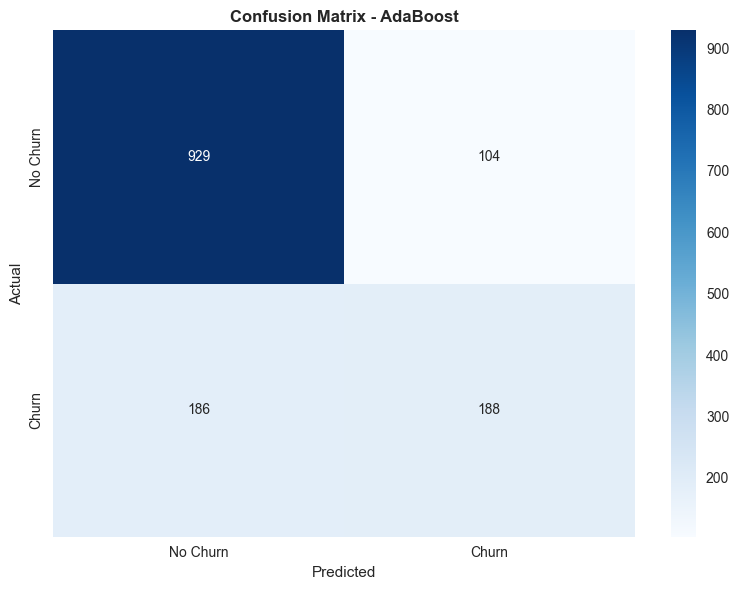

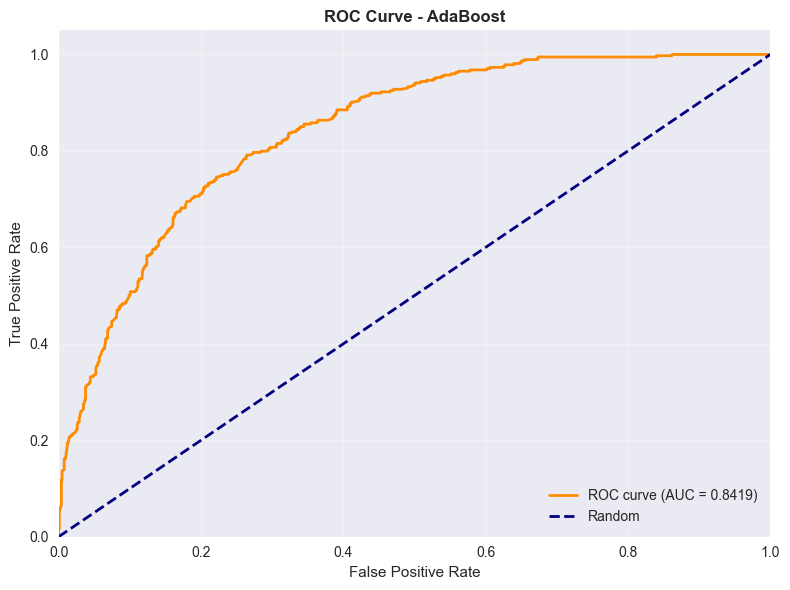

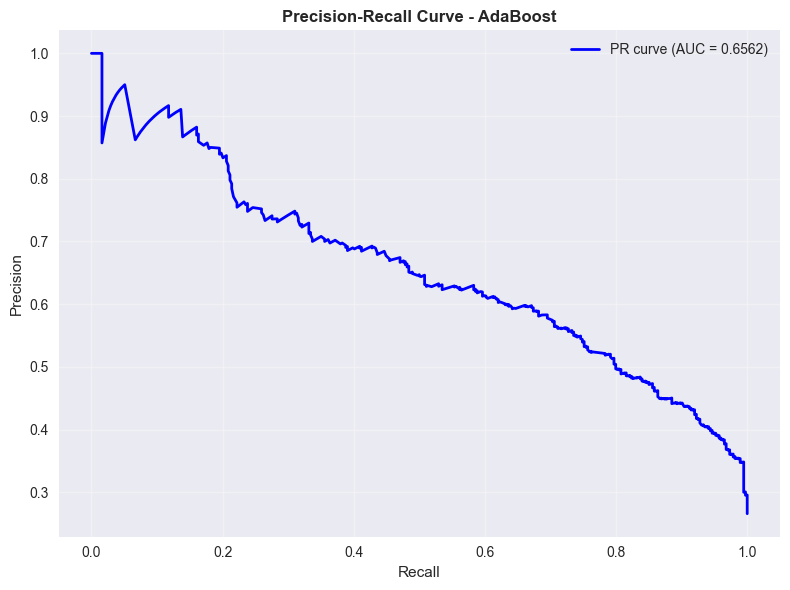

✓ Final model saved as AdaBoost


In [35]:

# === STEP 8: FINAL MODEL EVALUATION ===
print("\n" + "="*50)
print("STEP 8: FINAL MODEL EVALUATION")
print("="*50)

# Train the best model on full training set
final_model = tuned_models[best_model]
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print(f"Final Model Performance ({best_model}):")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<10}: {value:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model}', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model}', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/precision_recall_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Save the final model
joblib.dump(final_model, f"{OUTPUT_DIR}/models/final_model.pkl")
print(f"✓ Final model saved as {best_model}")



STEP 9: SHAP EXPLAINABILITY ANALYSIS
Generating SHAP explanations...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


background_data shape: (50, 30)
test_data shape: (50, 30)
X.columns shape: (30,)
shap_values shape: (50, 30)


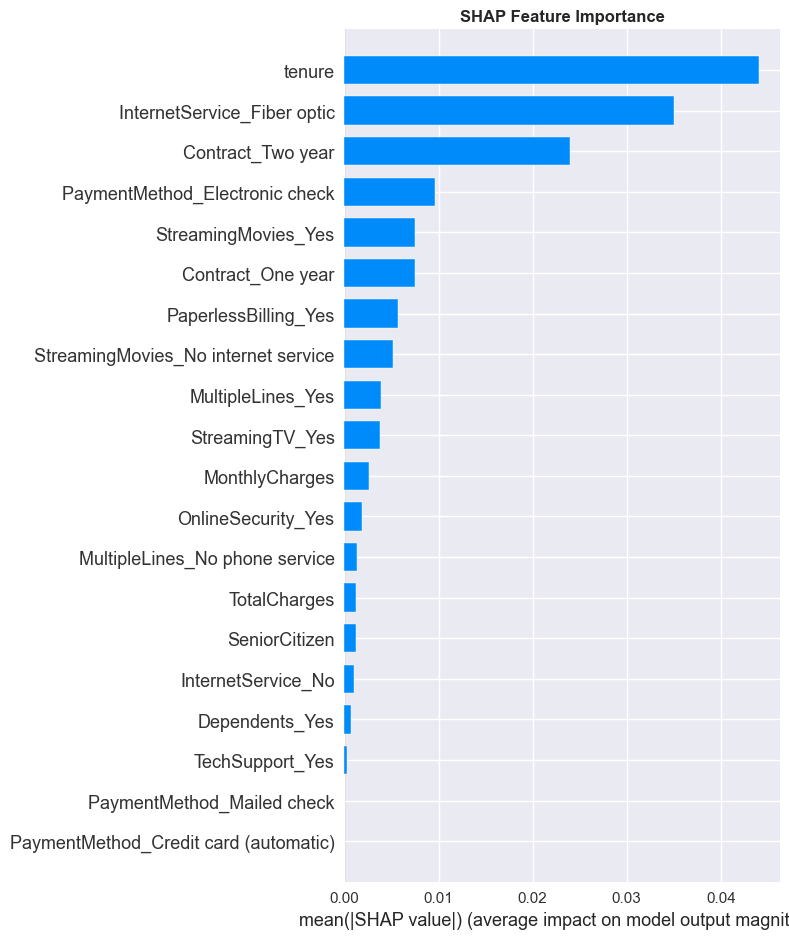

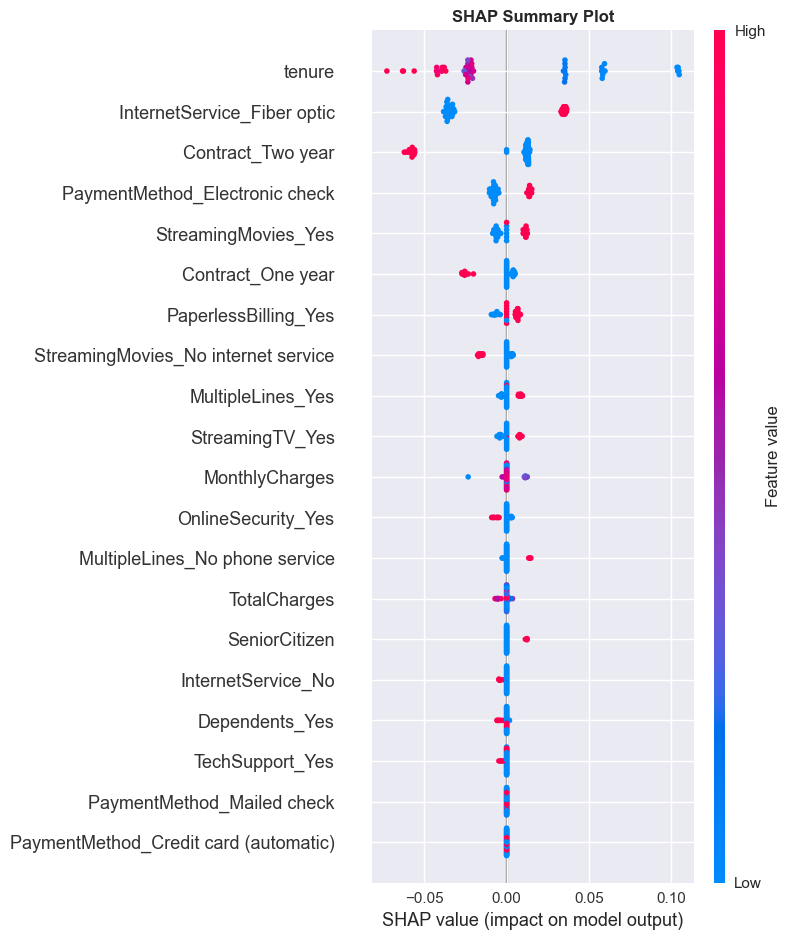

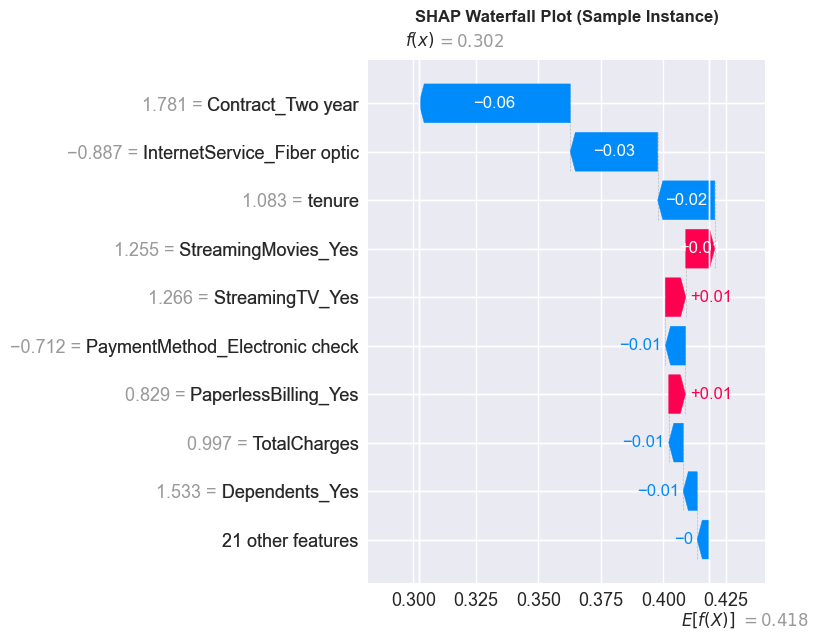

In [36]:
# === STEP 9: SHAP EXPLAINABILITY ANALYSIS ===
print("\n" + "="*50)
print("STEP 9: SHAP EXPLAINABILITY ANALYSIS")
print("="*50)

print("Generating SHAP explanations...")
# Use KernelExplainer for AdaBoostClassifier
# Reduce background and test sample size for faster computation
n_samples = 50
background_data = X_train[:n_samples]
test_data = X_test[:n_samples]

# Ensure predict_proba returns probabilities for both classes
explainer = shap.KernelExplainer(lambda x: final_model.predict_proba(x)[:, 1], background_data)
shap_values = explainer.shap_values(test_data)  # Compute SHAP values for positive class

# Debug shapes
print("background_data shape:", background_data.shape)
print("test_data shape:", test_data.shape)
print("X.columns shape:", X.columns.shape)
print("shap_values shape:", shap_values.shape)

# Ensure feature names match
features_df = pd.DataFrame(test_data, columns=X.columns)

# Feature importance plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, features=features_df, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, features=features_df, show=False)
plt.title('SHAP Summary Plot', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# SHAP waterfall plot for first instance
plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                    base_values=explainer.expected_value,
                                    data=test_data[0],
                                    feature_names=X.columns.tolist()), show=False)
plt.title('SHAP Waterfall Plot (Sample Instance)', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_waterfall.png", dpi=300, bbox_inches='tight')
plt.show()

In [37]:

# === STEP 10: SAVE RESULTS AND DATA ===
print("\n" + "="*50)
print("STEP 10: SAVING RESULTS AND DATA")
print("="*50)

# Save cross-validation results
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.to_csv(f"{OUTPUT_DIR}/data/cv_results.csv", index=False)
print("✓ Cross-validation results saved")

# Save comprehensive metrics
metrics_df = pd.DataFrame({
    'Model': list(tuned_models.keys()),
    'ROC_AUC_mean': [metrics_results[m]['roc_auc'].mean() for m in tuned_models.keys()],
    'ROC_AUC_std': [metrics_results[m]['roc_auc'].std() for m in tuned_models.keys()],
    'Accuracy_mean': [metrics_results[m]['accuracy'].mean() for m in tuned_models.keys()],
    'Accuracy_std': [metrics_results[m]['accuracy'].std() for m in tuned_models.keys()],
    'Precision_mean': [metrics_results[m]['precision'].mean() for m in tuned_models.keys()],
    'Precision_std': [metrics_results[m]['precision'].std() for m in tuned_models.keys()],
    'Recall_mean': [metrics_results[m]['recall'].mean() for m in tuned_models.keys()],
    'Recall_std': [metrics_results[m]['recall'].std() for m in tuned_models.keys()],
    'F1_mean': [metrics_results[m]['f1'].mean() for m in tuned_models.keys()],
    'F1_std': [metrics_results[m]['f1'].std() for m in tuned_models.keys()]
})
metrics_df.to_csv(f"{OUTPUT_DIR}/data/model_performance_metrics.csv", index=False)
print("✓ Model performance metrics saved")

# Save statistical test results
stats_df = pd.DataFrame({
    'Model': list(significance_results.keys()),
    'Wilcoxon_p_value': list(significance_results.values()),
    'Significant_at_0.05': [p < 0.05 for p in significance_results.values()]
})
stats_df.to_csv(f"{OUTPUT_DIR}/data/statistical_tests.csv", index=False)
print("✓ Statistical test results saved")

# Save final test metrics
final_metrics_df = pd.DataFrame([test_metrics])
final_metrics_df.to_csv(f"{OUTPUT_DIR}/data/final_model_metrics.csv", index=False)
print("✓ Final model metrics saved")

# Save feature names
feature_names_df = pd.DataFrame({'Feature': X.columns})
feature_names_df.to_csv(f"{OUTPUT_DIR}/data/feature_names.csv", index=False)
print("✓ Feature names saved")

# Save processed dataset
df_processed = pd.DataFrame(X_scaled, columns=X.columns)
df_processed['target'] = y
df_processed.to_csv(f"{OUTPUT_DIR}/data/processed_dataset.csv", index=False)
print("✓ Processed dataset saved")

# === ANALYSIS SUMMARY ===
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"✓ Dataset: {df.shape} → {X.shape} (after preprocessing)")
print(f"✓ Best Model: {best_model} (ROC-AUC: {cv_results[best_model].mean():.4f})")
print(f"✓ Test Performance: {test_metrics['roc_auc']:.4f} ROC-AUC")
print(f"✓ Statistical Tests: Wilcoxon & Friedman completed")
print(f"✓ SHAP Analysis: Feature importance and explanations generated")
print(f"✓ All outputs saved to: {OUTPUT_DIR}/")
print(f"  - Plots: {len(os.listdir(f'{OUTPUT_DIR}/plots'))} files")
print(f"  - Data: {len(os.listdir(f'{OUTPUT_DIR}/data'))} files")
print(f"  - Models: {len(os.listdir(f'{OUTPUT_DIR}/models'))} files")
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Display final metrics table for journal
print("\nFINAL RESULTS TABLE (For Journal Publication):")
print("="*80)
print(metrics_df.round(4).to_string(index=False))
print("="*80)


STEP 10: SAVING RESULTS AND DATA
✓ Cross-validation results saved
✓ Model performance metrics saved
✓ Statistical test results saved
✓ Final model metrics saved
✓ Feature names saved
✓ Processed dataset saved

ANALYSIS SUMMARY
✓ Dataset: (7032, 20) → (7032, 30) (after preprocessing)
✓ Best Model: AdaBoost (ROC-AUC: 0.8484)
✓ Test Performance: 0.8419 ROC-AUC
✓ Statistical Tests: Wilcoxon & Friedman completed
✓ SHAP Analysis: Feature importance and explanations generated
✓ All outputs saved to: rill_final/
  - Plots: 9 files
  - Data: 6 files
  - Models: 2 files

Analysis completed at: 2025-06-16 22:59:24

FINAL RESULTS TABLE (For Journal Publication):
             Model  ROC_AUC_mean  ROC_AUC_std  Accuracy_mean  Accuracy_std  Precision_mean  Precision_std  Recall_mean  Recall_std  F1_mean  F1_std
               GBM        0.8477       0.0061         0.8035        0.0111          0.6739         0.0318       0.5072      0.0301   0.5782  0.0251
           XGBoost        0.8476       0.005